# S&P500 Annual Return Forecasts–Joint Portfolio Outcomes

Late 2025, early 2026 US investment banks pulshied their annual return forecasts for the S&P500 index. The S&P500, given its positive correlation with the *Portfolio*, serves as a good instrument to conduct joint scenario analysis for posterior distributions.

This analysis relies on the institutional forecasts summarised by the Financial Times:
https://www.ft.com/content/0c133aab-0e90-44d1-9709-2c1359a86758

In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance pandoc

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 209.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 159.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 205.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 178.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 174.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 147.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 202.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 165.2 MB/s eta 0:00:00
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34792 sha256=0efe20bd449bec091aed598d324a67478c9d35d8e

In [10]:
import numpy as np
import pandas as pd
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [21]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
benchmark = '^GSPC'
all_assets = selected_assets + [benchmark]
existing_assets = [c for c in all_assets if c in data.columns]
data = data[existing_assets]
data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')

pnl = np.diff(np.log(data_clean.values), axis=0)
pnl = pd.DataFrame(pnl, index=data_clean.index[1:], columns=data_clean.columns)
print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

#%% 2. Portfolio Weights (20-fold exposure stacking)
exposures = np.array([
    0.0413,  # NVDA
    0.0516,  # ISRG
    0.0414,  # APO
    0.0597,  # DECK
    0.1624,  # COST
    0.0901,  # CAT
    0.0240,  # BTU
    0.0992,  # SHW
    0.0790,  # NRG
    0.0707,  # NFLX
    0.0519,  # CBRE
    0.2286,  # GC=F
])

R_investable = pnl[selected_assets].values
R_benchmark = pnl[benchmark].values
portfolio_return = R_investable @ exposures

Returns: 2470 days × 13 assets
Date range: 2016-01-05 → 2025-11-11


In [22]:
H = 252
returns_2d = np.column_stack([portfolio_return, R_benchmark])
means = np.mean(returns_2d, axis=0) * H
vols = np.std(returns_2d, axis=0) * np.sqrt(H)
corr = np.corrcoef(returns_2d.T)
covariances = np.diag(vols) @ corr @ np.diag(vols)

print(f"Portfolio: mean={means[0]*100:.1f}%")
print(f"S&P 500:   mean={means[1]*100:.1f}%")
print(f"Correlation: {corr[0,1]:.3f}")

Portfolio: mean=21.2%
S&P 500:   mean=12.5%
Correlation: 0.887


In [23]:
S = 10000
np.random.seed(1337)
log_return = np.random.multivariate_normal(means, covariances, S)
discrete_return = pd.DataFrame(
    np.exp(log_return - np.diag(np.cov(log_return.T)) / 2) - 1,
    columns=['Portfolio', 'S&P 500'])

p = np.ones((S, 1)) / S
prior_stats = ft.simulation_moments(discrete_return, p)
prior_mean_sp = prior_stats['Mean']['S&P 500']
prior_vol_sp = prior_stats['Volatility']['S&P 500']

In [30]:
bank_views = {
    'Deutsche Bank':     0.167,
    'Morgan Stanley':    0.138,
    'UBS':               0.123,
    'JP Morgan':         0.094,
    'HSBC':              0.094,
    'BNP Paribas':       0.094,
    'Goldman Sachs':     0.090,
    'Barclays':          0.079,
    'Société Générale':  0.065,
    'Bank of America':   0.065,
}

avg_forecast = np.mean(list(bank_views.values()))
bank_views['Avg Forecast'] = avg_forecast

vol_mult = 1
view_vol = vol_mult * prior_vol_sp

print(f"\n{'Bank':<20} {'S&P View':>10}")
print("-" * 32)
for bank, view_mean in bank_views.items():
    print(f"{bank:<20} {view_mean*100:>9.1f}%")


Bank                   S&P View
--------------------------------
Deutsche Bank             16.7%
Morgan Stanley            13.8%
UBS                       12.3%
JP Morgan                  9.4%
HSBC                       9.4%
BNP Paribas                9.4%
Goldman Sachs              9.0%
Barclays                   7.9%
Société Générale           6.5%
Bank of America            6.5%
Avg Forecast              10.1%


In [31]:
posterior_probs = {}
posterior_stats = {}

print(f"\n{'Bank':<20} {'S&P View':>9} {'Port Mean':>11} {'Eff. Scen.':>12}")
print("-" * 55)

for bank, view_mean in bank_views.items():
    A = np.ones((1, S))
    A = np.vstack((A, discrete_return['S&P 500'].values))
    A = np.vstack((A, discrete_return['S&P 500'].values**2))
    b = np.array([[1., view_mean, view_vol**2 + view_mean**2]]).T
    
    q = ft.entropy_pooling(p, A, b)
    
    relative_entropy = (q.T @ (np.log(q) - np.log(p)))[0, 0]
    effective_scenarios = np.exp(-relative_entropy)
    
    posterior_probs[bank] = q
    
    stats = ft.simulation_moments(discrete_return, p=q)
    port_mean = stats['Mean']['Portfolio']
    
    posterior_stats[bank] = {
        'view_mean': view_mean,
        'port_mean': port_mean,
        'eff_scenarios': effective_scenarios
    }
    
    print(f"{bank:<20} {view_mean*100:>8.1f}% {port_mean*100:>10.1f}% {effective_scenarios*100:>11.0f}%")


Bank                  S&P View   Port Mean   Eff. Scen.
-------------------------------------------------------
Deutsche Bank            16.7%       26.7%          99%
Morgan Stanley           13.8%       24.0%         100%
UBS                      12.3%       22.6%         100%
JP Morgan                 9.4%       20.0%          98%
HSBC                      9.4%       20.0%          98%
BNP Paribas               9.4%       20.0%          98%
Goldman Sachs             9.0%       19.6%          97%
Barclays                  7.9%       18.6%          96%
Société Générale          6.5%       17.3%          93%
Bank of America           6.5%       17.3%          93%
Avg Forecast             10.1%       20.6%          99%


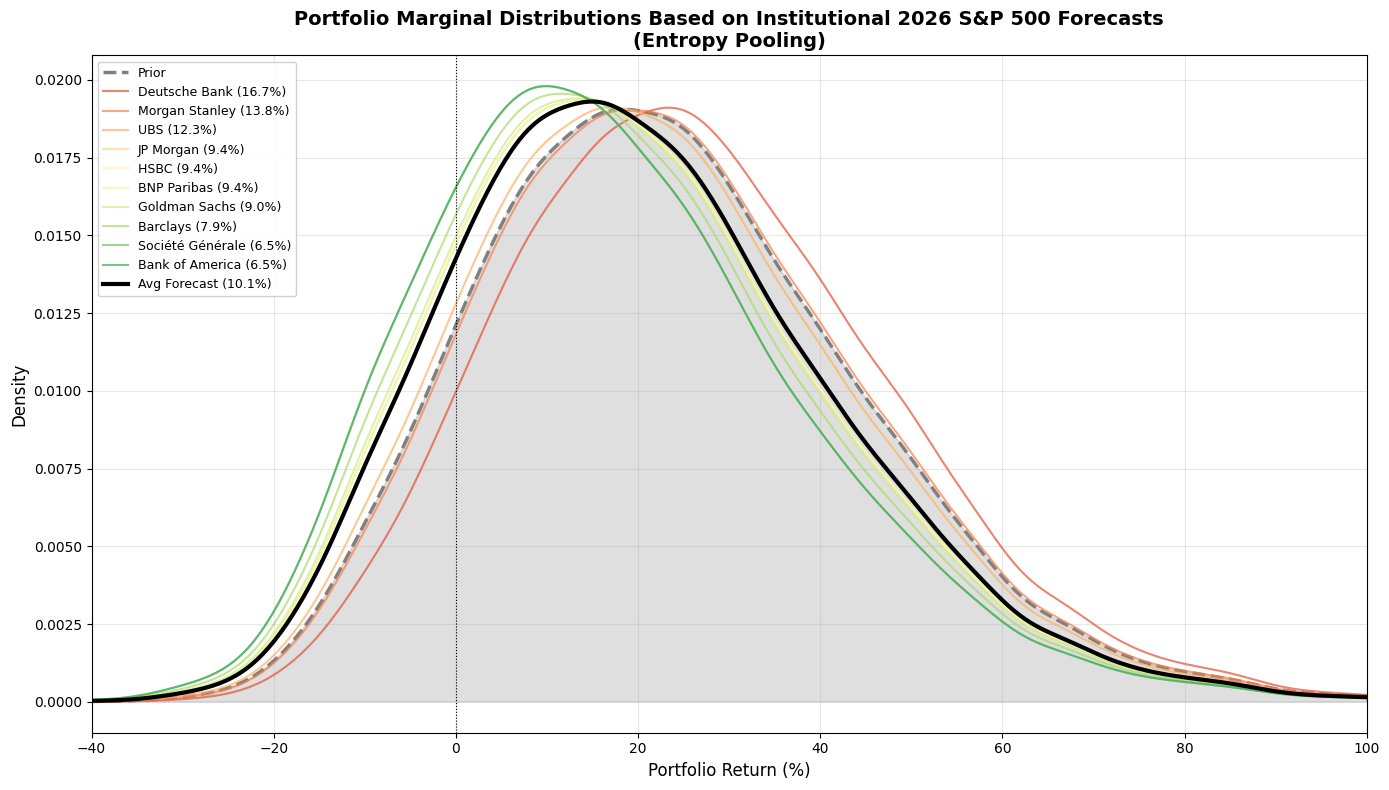

In [34]:
fig, ax = plt.subplots(figsize=(14, 8))

portfolio_returns_pct = discrete_return['Portfolio'].values * 100
x_range = np.linspace(-60, 100, 500)

n_banks = len(bank_views) - 1  # exclude avg for color scale
colors = plt.cm.RdYlGn(np.linspace(0.15, 0.85, n_banks))

kde_prior = gaussian_kde(portfolio_returns_pct, weights=p.flatten())
ax.fill_between(x_range, kde_prior(x_range), alpha=0.25, color='gray')
ax.plot(x_range, kde_prior(x_range), color='gray', lw=2.5, ls='--', label='Prior')

individual_banks = {k: v for k, v in bank_views.items() if k != 'Avg Forecast'}
sorted_banks = sorted(individual_banks.keys(), key=lambda x: -bank_views[x])

for i, bank in enumerate(sorted_banks):
    q = posterior_probs[bank]
    view_pct = bank_views[bank] * 100
    kde = gaussian_kde(portfolio_returns_pct, weights=q.flatten())
    ax.plot(x_range, kde(x_range), color=colors[i], lw=1.5, alpha=0.7,
            label=f'{bank} ({view_pct:.1f}%)')

q_avg = posterior_probs['Avg Forecast']
kde_avg = gaussian_kde(portfolio_returns_pct, weights=q_avg.flatten())
ax.plot(x_range, kde_avg(x_range), color='black', lw=3, 
        label=f'Avg Forecast ({avg_forecast*100:.1f}%)')

ax.set_xlabel('Portfolio Return (%)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Portfolio Marginal Distributions Based on Institutional 2026 S&P 500 Forecasts\n(Entropy Pooling)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.axvline(0, color='black', lw=0.8, ls=':')
ax.set_xlim(-40, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bank_forecasts_portfolio_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
summary_df = pd.DataFrame(posterior_stats).T
summary_df.columns = ['S&P View', 'Portfolio Mean', 'Eff. Scenarios']
summary_df = summary_df.sort_values('S&P View', ascending=False)
summary_df_pct = (summary_df * 100).round(1)
summary_df_pct.columns = ['S&P View (%)', 'Portfolio Mean (%)', 'Eff. Scenarios (%)']
print(summary_df_pct)

prior_port_mean = prior_stats['Mean']['Portfolio']
print(f"\nPrior (no view): Portfolio mean={prior_port_mean:.1%}")

                  S&P View (%)  Portfolio Mean (%)  Eff. Scenarios (%)
Deutsche Bank             16.7                26.7                98.5
Morgan Stanley            13.8                24.0               100.0
UBS                       12.3                22.6                99.9
Avg Forecast              10.1                20.6                98.5
JP Morgan                  9.4                20.0                97.8
BNP Paribas                9.4                20.0                97.8
HSBC                       9.4                20.0                97.8
Goldman Sachs              9.0                19.6                97.4
Barclays                   7.9                18.6                95.9
Société Générale           6.5                17.3                93.5
Bank of America            6.5                17.3                93.5

Prior (no view): Portfolio mean=23.6%
